In [1]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# RDM 3directions

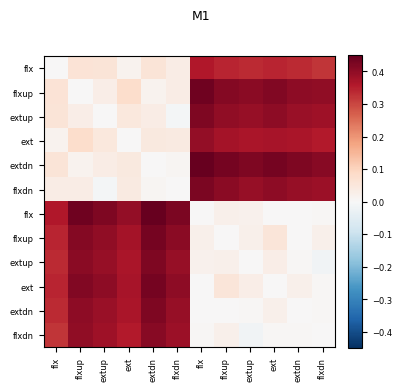

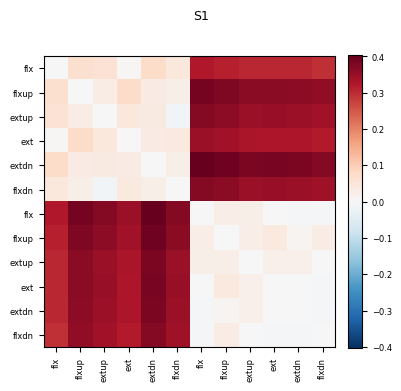

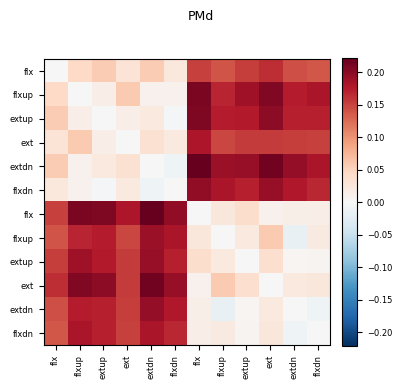

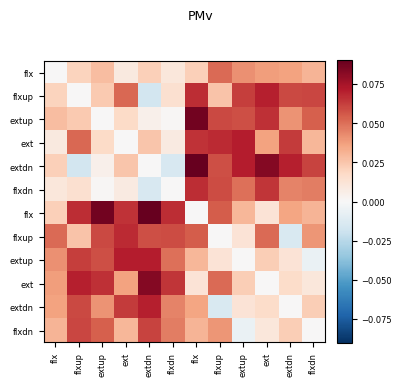

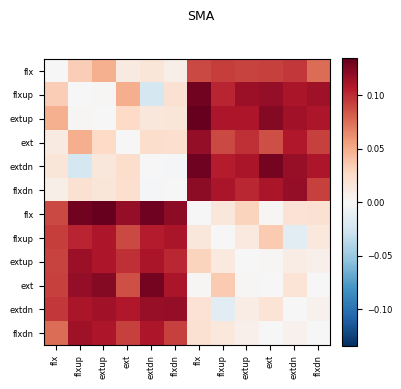

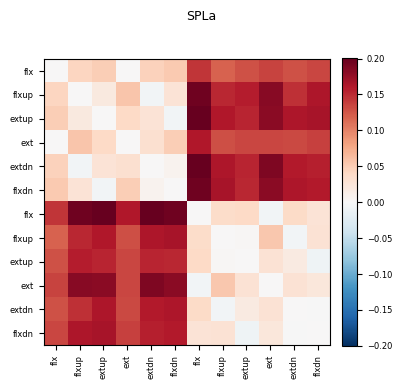

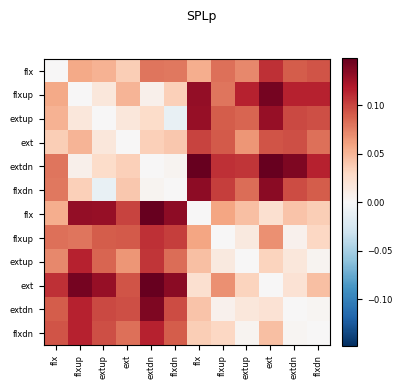

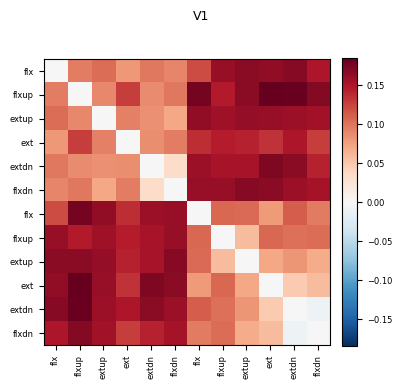

In [3]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
select_conds = ['flx', 'flxup', 'extup']
select_conds = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

RDMs_unimanual = {'sn': [], 'region':[], 'hem':[], 'labels': [], 'G': [], 'D^2': []}

for i_region, region in enumerate(regions):
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)
        data, cond_vec, part_vec = [], [], []

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c and any(c == f'rhand:{cond}' for cond in select_conds)]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c and any(c == f'lhand:{cond}' for cond in select_conds)]
            idx = idx1 + idx2
            Y = data_tmp[i_sub][idx, :]
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

        Y = []
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
    
        N = len(Y)
        ncond = len(select_conds)*2
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
            RDMs_unimanual['sn'].append(subject[i_sub])
            RDMs_unimanual['region'].append(region)
            RDMs_unimanual['hem'].append(h)
            RDMs_unimanual['labels'].append(labels)
            RDMs_unimanual['G'].append(G_hat[i_sub, :, :])
            dist = pcm.G_to_dist(G_hat[i_sub, :, :])
            RDMs_unimanual['D^2'].append(dist)

RDMs_unimanual = pd.DataFrame(RDMs_unimanual)
RDMs_unimanual.to_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))

# PLOT:
plt.rcParams.update({'font.size': 6})
cmap = 'RdBu_r'
for region in regions:
    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='L')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_L = np.mean(D, axis=0)
    G = tmp['G'].to_list()
    G = np.array(G)
    G_avg_L = np.mean(G, axis=0)

    tmp = RDMs_unimanual[(RDMs_unimanual['region']==region) & (RDMs_unimanual['hem']=='R')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_R = np.mean(D, axis=0)
    G = tmp['G'].to_list()
    G = np.array(G)
    G_avg_R = np.mean(G, axis=0)

    fig, ax = plt.subplots(1,1, figsize=(4,4))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    d = D_avg_L/2 + D_avg_R/2
    plt.sca(ax)
    vmin = -np.max(np.abs(d))
    vmax = np.max(np.abs(d))
    im = ax.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(list(range(len(labels))))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(list(range(len(labels))))
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.show()



# MDS

2D coordinates:
[[ 0.14630798  0.00756403]
 [ 0.21542533 -0.03332746]
 [ 0.20092473 -0.01528656]
 [ 0.17491655  0.02841224]
 [ 0.23142246  0.01083987]
 [ 0.20392336  0.00542929]
 [-0.21984793  0.00478422]
 [-0.19756368 -0.01834816]
 [-0.18860623 -0.00745258]
 [-0.19778448  0.02453967]
 [-0.18893299 -0.0165198 ]
 [-0.18018508  0.00936523]]

Eigenvalues: [0.4641396  0.00373374]

3D coordinates:
[[ 0.14630798  0.00756403  0.00780274]
 [ 0.21542533 -0.03332746  0.00657642]
 [ 0.20092473 -0.01528656 -0.01121392]
 [ 0.17491655  0.02841224 -0.02215344]
 [ 0.23142246  0.01083987  0.00192329]
 [ 0.20392336  0.00542929  0.01641108]
 [-0.21984793  0.00478422  0.01036852]
 [-0.19756368 -0.01834816 -0.02216402]
 [-0.18860623 -0.00745258  0.00711296]
 [-0.19778448  0.02453967  0.00161334]
 [-0.18893299 -0.0165198  -0.00117794]
 [-0.18018508  0.00936523  0.00490098]]

Eigenvalues: [0.4641396  0.00373374 0.00167104]


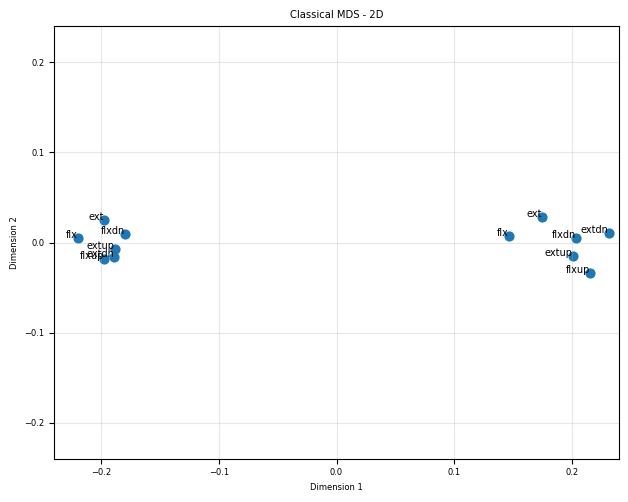

In [16]:
import numpy as np
import matplotlib.cm as cm
import plotly.graph_objects as go

def plot_mds_3d_interactive(coords_3d, labels=None):
    """
    Create an interactive 3D scatter plot for MDS results with equal axes.
    
    Parameters:
    -----------
    coords_3d : numpy.array
        3D coordinates from MDS (N x 3)
    labels : list or None
        Labels for each point (default: numerical indices)
    """
    if labels is None:
        labels = [str(i) for i in range(len(coords_3d))]

    colors = []
    for i in range(len(labels)):
        if i < len(labels)/2:
            colors.append(cm.Blues(i / (len(labels)/2)))
        else:
            colors.append(cm.Reds((i - len(labels)/2) / (len(labels)/2)))
    # make it numpy array, N by 4 RGBA
    colors = np.array(colors)
    colors_hex = [mcolors.to_hex(color) for color in colors]

    # Calculate equal axis limits
    max_range = np.max([
        np.max(coords_3d[:, 0]) - np.min(coords_3d[:, 0]),
        np.max(coords_3d[:, 1]) - np.min(coords_3d[:, 1]),
        np.max(coords_3d[:, 2]) - np.min(coords_3d[:, 2])
    ]) / 2.0
    
    mid_x = (np.max(coords_3d[:, 0]) + np.min(coords_3d[:, 0])) / 2.0
    mid_y = (np.max(coords_3d[:, 1]) + np.min(coords_3d[:, 1])) / 2.0
    mid_z = (np.max(coords_3d[:, 2]) + np.min(coords_3d[:, 2])) / 2.0
    
    fig = go.Figure(data=[go.Scatter3d(
        x=coords_3d[:, 0],
        y=coords_3d[:, 1],
        z=coords_3d[:, 2],
        mode='markers+text',
        marker=dict(
            size=8,
            color=colors_hex,
            showscale=True,
            colorbar=dict(title="Dimension 3")
        ),
        text=labels,
        textposition="top center",
        textfont=dict(size=12),
        hovertemplate='<b>%{text}</b><br>' +
                      'Dim 1: %{x:.3f}<br>' +
                      'Dim 2: %{y:.3f}<br>' +
                      'Dim 3: %{z:.3f}<br>' +
                      '<extra></extra>'
    )])
    
    fig.update_layout(
        title='Interactive 3D MDS Visualization',
        scene=dict(
            xaxis=dict(
                title='Dimension 1',
                range=[mid_x - max_range, mid_x + max_range]
            ),
            yaxis=dict(
                title='Dimension 2',
                range=[mid_y - max_range, mid_y + max_range]
            ),
            zaxis=dict(
                title='Dimension 3',
                range=[mid_z - max_range, mid_z + max_range]
            ),
            aspectmode='cube',  # Force equal aspect ratio
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=700,
        hovermode='closest'
    )
    
    return fig

def classical_mds(D, n_components=2):
    """
    Classical Multidimensional Scaling (MDS) on a dissimilarity matrix.
    
    Also known as Principal Coordinates Analysis (PCoA) or Torgerson's scaling.
    
    Parameters:
    -----------
    D : numpy.array
        Symmetric dissimilarity/distance matrix (N x N)
    n_components : int, default=2
        Number of dimensions for the output (2 or 3 for visualization)
    
    Returns:
    --------
    Y : numpy.array
        Configuration matrix (N x n_components) with embedded coordinates
    eigenvalues : numpy.array
        Eigenvalues corresponding to the dimensions
    """
    # Number of points
    n = len(D)
    
    # Centering matrix
    H = np.eye(n) - np.ones((n, n)) / n
    
    # Double centering: B = -0.5 * H * D^2 * H
    B = -H.dot(D**2).dot(H) / 2
    
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(B)
    
    # Sort by eigenvalue in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select only positive eigenvalues and corresponding eigenvectors
    positive_idx = eigenvalues > 0
    eigenvalues = eigenvalues[positive_idx]
    eigenvectors = eigenvectors[:, positive_idx]
    
    # Compute coordinates for the requested number of components
    n_components = min(n_components, len(eigenvalues))
    Y = eigenvectors[:, :n_components] @ np.diag(np.sqrt(eigenvalues[:n_components]))
    
    return Y, eigenvalues[:n_components]

region = 'M1'

np.random.seed(42)
tmp = RDMs_unimanual[(RDMs_unimanual['region']==region)]
labels = tmp['labels'].values[0]
D = tmp['D^2'].to_list()
D = np.array(D)
D = np.sign(D) * np.sqrt(np.abs(D))
D = np.mean(D, axis=0)
# D = np.abs(D)

# Perform classical MDS to 2D
coords_2d, eigenvals_2d = classical_mds(D, n_components=2)
print("2D coordinates:")
print(coords_2d)
print("\nEigenvalues:", eigenvals_2d)

# Perform classical MDS to 3D
coords_3d, eigenvals_3d = classical_mds(D, n_components=3)
print("\n3D coordinates:")
print(coords_3d)
print("\nEigenvalues:", eigenvals_3d)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# 2D plot
plt.subplot(121)
plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=40)
for i in range(len(coords_2d)):
    plt.annotate(f'{labels[i]}', (coords_2d[i, 0], coords_2d[i, 1]), 
                fontsize=7, ha='right')
# Set equal aspect ratio and apply x/y limits after plotting
max_range = 0.24
plt.xlim((-max_range, max_range))
plt.ylim((-max_range, max_range))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Classical MDS - 2D')
plt.grid(True, alpha=0.3)

# 3D plot
# from mpl_toolkits.mplot3d import Axes3D
# ax = plt.subplot(122, projection='3d')
# ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2], s=20)
# for i in range(len(coords_3d)):
#     ax.text(coords_3d[i, 0], coords_3d[i, 1], coords_3d[i, 2], 
#             f'{labels[i]}', fontsize=12)
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_zlabel('Dimension 3')
# ax.set_title('Classical MDS - 3D')

plt.tight_layout()
plt.show()

# Create labels (e.g., condition names)
# labels = [f'Condition {i+1}' for i in range(12)]
labels = tmp['labels'].values[0]
# Plot
fig = plot_mds_3d_interactive(coords_3d, labels=labels)
fig.show()

